Import packages.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "none"
from matplotlib.patches import Circle, Ellipse
from scipy.stats import multivariate_normal
import numpy.linalg as la
from mpl_toolkits.mplot3d import Axes3D

## 3. Assignment - Part I

### 3.1. Batch mode training using least squares - supervised learning of network weights

Define the data.

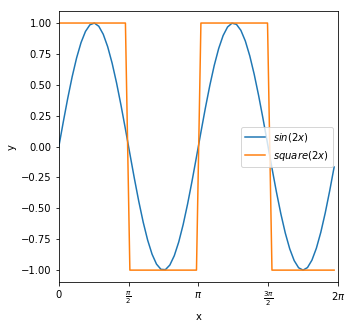

In [2]:
def functions(x, noise_variance=None):
    y_sin = np.sin(2*x)
    y_square = np.sign(y_sin)
    y_square[y_square==0] = 1
    if noise_variance is not None:
        std = np.sqrt(noise_variance)
        y_sin += np.random.normal(scale=std, size=y_sin.shape)
        y_square += np.random.normal(scale=std, size=y_square.shape)
    return y_sin, y_square

x = np.arange(0, 2*np.pi, 0.1)[:,np.newaxis]
x_test = np.arange(0.05, 2*np.pi, 0.1)[:,np.newaxis]
y_sin, y_square = functions(x, noise_variance=None)
y_sin_test, y_square_test = functions(x_test, noise_variance=None)

# Plot functions
plt.figure(figsize=(5,5))
plt.plot(x, y_sin, label="$sin(2x)$")
plt.plot(x, y_square, label="$square(2x)$")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
labels = ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",r"$2\pi$"]
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), labels)
plt.legend()

Define the class for training Gaussian Radial Basis Functions.

In [3]:
DEFAULT_NODES = 10
DEFAULT_NODE_POS = 'equal'
DEFAULT_NODE_STD = 1
DEFAULT_CL_SYMMETRICAL = False
DEFAULT_CL_RANDOM_START = True
DEFAULT_CL_LEARNING_RATE = 0.2
DEFAULT_CL_EPOCHS = 100
DEFAULT_CL_BIAS = False
DEFAULT_CL_BIAS_WEIGHT = 0.01
DEFAULT_CL_VERBOSE = False
DEFAULT_LEARNING_RATE_DELTA = 0.1
DEFAULT_EPOCHS_DELTA = 100
DEFAULT_SHUFFLE_DELTA = False
DEFAULT_POSTPROCESSING = None
DEFAULT_TRAINING = 'least_squares'
DEFAULT_RUNS = 10

class GaussianRBFNetwork:

    def __init__(self,
                 data,
                 nodes=DEFAULT_NODES,
                 node_pos=DEFAULT_NODE_POS,
                 node_std=DEFAULT_NODE_STD,
                 cl_symmetrical=DEFAULT_CL_SYMMETRICAL,
                 cl_random_start=DEFAULT_CL_RANDOM_START,
                 cl_learning_rate=DEFAULT_CL_LEARNING_RATE,
                 cl_epochs=DEFAULT_CL_EPOCHS,
                 cl_bias=DEFAULT_CL_BIAS,
                 cl_bias_weight=DEFAULT_CL_BIAS_WEIGHT,
                 cl_verbose=DEFAULT_CL_VERBOSE,
                 postprocessing=DEFAULT_POSTPROCESSING
                ):

        self.data = data
        self.nodes = nodes
        self.node_pos = node_pos
        self.postprocessing = postprocessing
        
        # Define initial node position by competitive learning
        if self.node_pos=='cl':
            self.init_kernels_cl(std=node_std,
                                 random_start=cl_random_start,
                                 learning_rate=cl_learning_rate,
                                 epochs=cl_epochs,
                                 bias=cl_bias,
                                 bias_weight=cl_bias_weight,
                                 verbose=cl_verbose)
        
        # Define initial node position randomly
        elif self.node_pos=='random':
            self.mu = np.array([self.data[np.random.randint(self.data.shape[0]),:] \
                                for _ in range(self.nodes)])
            self.cov = np.full(self.nodes, node_std**2)
        
        # Define initial node position equally
        elif self.node_pos=='equal':
            low, high = self.data[0], self.data[-1]
            self.mu = np.linspace(low, high, self.nodes)
            self.cov = np.full(self.nodes, node_std**2)
        
        # Define initial node position manually
        elif self.node_pos=='manual':
            pass
        
        # Initialize the weights that connect to the output layer
        self.weights = np.random.randn(self.nodes, 1)
        
    def init_kernels_cl(self,
                        std=DEFAULT_NODE_STD,
                        random_start=DEFAULT_CL_RANDOM_START,
                        learning_rate=DEFAULT_CL_LEARNING_RATE,
                        epochs=DEFAULT_CL_EPOCHS,
                        bias=DEFAULT_CL_BIAS,
                        bias_weight=DEFAULT_CL_BIAS_WEIGHT,
                        verbose=DEFAULT_CL_VERBOSE):
        
        # Define the units centers and covariances (if required)
        if random_start:
            self.mu = np.array([self.data[np.random.randint(self.data.shape[0]),:] \
                                for _ in range(self.nodes)])
            self.cov = np.full(self.nodes, std**2)        
        
        # Intialize the matrix for counting the winners
        winnings = np.zeros((self.mu.shape[0],1), dtype=int)
        
        # Define the bias matrix for penalizing winners (if required)
        if bias:
            biases = np.full((self.mu.shape[0],1), 1/self.nodes)
        
        # Iterate the epochs of competitive learning process
        samples_ = self.data.copy()
        for i in range(epochs):
            
            # Shufflle and iterate the samples
            np.random.shuffle(samples_)
            for sample in samples_:
                
                # Compute the error of the sample to each unit
                err = sample-self.mu
                
                # Compute the distances from the sample to each unit
                d = np.sum(err*err, axis=1).reshape(self.nodes, 1)
                
                # Penalize the winners
                if bias:
                    d -= bias_weight*biases
                
                # Find the winners (closest unit to the sample)
                i = np.argmin(d)
                self.mu[i,:] += learning_rate*err[i,:]
                winnings[i] += 1
                
                # Update the bias for penalizing winners
                if bias:
                    biases = 1/self.nodes-winnings/(i+1)

        if verbose:
            print("CL summary:")
            print("  - Weights and Winning Times are:")
            for pos, wins in zip(self.mu, winnings):
                print(" x: ", pos, " -> ", wins[0])

    def least_squares_fit(self, inputs, outputs):
        phi = np.array([[multivariate_normal.pdf(x, mean=self.mu[i], cov=self.cov[i]) \
                         for i in range(self.nodes)] for x in inputs])
        self.weights, _, _, _ = la.lstsq(phi, np.ravel(outputs), rcond=None)
        self.weights = self.weights[:,np.newaxis]

    def delta_rule_train(self,
                         inputs,
                         outputs,
                         learning_rate=DEFAULT_LEARNING_RATE_DELTA,
                         epochs=DEFAULT_EPOCHS_DELTA,
                         shuffle=DEFAULT_SHUFFLE_DELTA,
                         improve=False):
        if not improve:
            self.weights = np.random.randn(self.nodes, 1)
        for _ in range(epochs):
            if shuffle:
                np.random.shuffle(inputs)
            for sample, expected in zip(inputs, outputs):
                phi = np.array([multivariate_normal.pdf(sample, mean=self.mu[i], cov=self.cov[i]) \
                                for i in range(self.nodes)])[:,np.newaxis]
                err = expected-phi.T@self.weights
                self.weights += learning_rate*err*phi

    def predict(self, inputs):
        # Predict the inputs
        pred = np.array([[multivariate_normal.pdf(x, mean=self.mu[i], cov=self.cov[i]) \
                          for i in range(self.nodes)] for x in inputs]) @ self.weights
        
        # Postpreporcess the inputs (if required)
        if self.postprocessing is not None:
            pred = self.postprocessing(pred)
        
        return pred

#### 3.1.1. Try to vary the number of units

In [4]:
def profile_nodes_sigma(x, x_test,
                        y, y_test,
                        nodes_profile,
                        nodes_preview,
                        kwargs_network={},
                        kwargs_training={}
                       ):

    if 'training' in kwargs_training:
        training = kwargs_training['training']
        kwargs_training.pop('training')
    else:
        training = DEFAULT_TRAINING
    
    if 'node_std' in kwargs_network:
        node_std = kwargs_network['node_std']
        kwargs_network.pop('node_std')
    else:
        node_std = DEFAULT_NODE_STD

    def fit_model(nodes, sigma=DEFAULT_NODE_STD):
        model = GaussianRBFNetwork(data=x, nodes=nodes, node_std=sigma, **kwargs_network)
        if training == 'least_squares':
            model.least_squares_fit(x, y)
        elif training == 'delta_rule':
            model.delta_rule_train(x, y, **kwargs_training)
        return model
    
    # Preview
    fig = plt.figure(figsize=(15,7.5))
    fig.add_subplot(221)
    plt.plot(x_test, y_test, label="Ground Truth")
    for ns in nodes_preview:
        model = fit_model(ns)
        predictions_test = model.predict(x_test)
        plt.plot(x_test, predictions_test, label=str(ns)+" units")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    
    # Profiling
    fig.add_subplot(222)
    for sigma in [node_std] if type(node_std) in [float,int] else node_std:
        residuals = []
        for ns in nodes_profile:
            model = fit_model(ns, sigma)
            predictions_test = model.predict(x_test)
            residuals.append(np.mean(np.abs(predictions_test-y_test.reshape(y_test.shape[0], 1))))
        plt.plot(nodes_profile, residuals,linestyle='--', marker='o', label="sigma="+str(sigma))
    plt.legend()
    plt.xlabel("Number of Units")
    plt.ylabel("Residual Error")
    for residual_threshold in [0.1,0.01,0.001]:
        plt.axhline(residual_threshold, color='r', linestyle='--')

Results for *Sin* function.

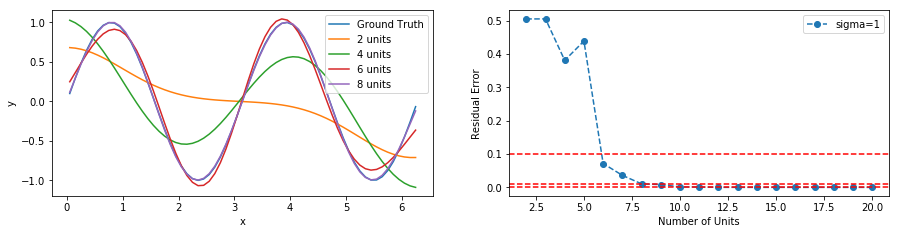

In [5]:
profile_nodes_sigma(x, x_test, y_sin, y_sin_test, nodes_profile=range(2, 21), nodes_preview=[2,4,6,8])

Results for *Square* function.

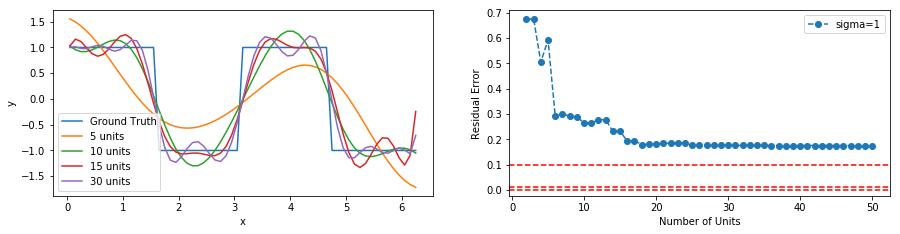

In [6]:
profile_nodes_sigma(x, x_test, y_square, y_square_test, nodes_profile=range(2, 51), 
                    nodes_preview=[5,10,15,30])

#### 3.1.2. Output transform for performance improvements

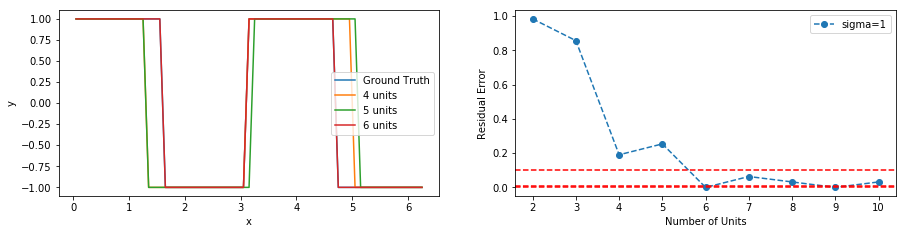

In [7]:
profile_nodes_sigma(x, x_test, y_square, y_square_test, nodes_profile=range(2, 11), nodes_preview=[4,5,6],
                    kwargs_network={'postprocessing': lambda prediction: np.sign(prediction)})

### 3.2  Regression with noise

Define the data.

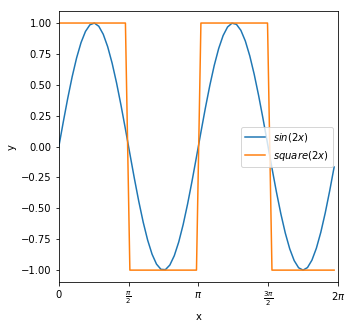

In [8]:
# Create noisy input functions
y_noisy_sin, y_noisy_square = functions(x, noise_variance=0.1)
y_test_noisy_sin, y_test_noisy_square = functions(x_test, noise_variance=0.1)

# Plot functions
plt.figure(figsize=(5,5))
plt.plot(x, y_sin, label="$sin(2x)$")
plt.plot(x, y_square, label="$square(2x)$")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim([0,2*np.pi])
plt.xticks(np.arange(0, 5/2*np.pi, np.pi/2), ["0",r"$\frac{\pi}{2}$",r"$\pi$",r"$\frac{3\pi}{2}$",
                                              r"$2\pi$"])
plt.legend()

#### 3.2.1. Compare the effect of the number of RBF units and their width for the two learning approaches

Least squares.

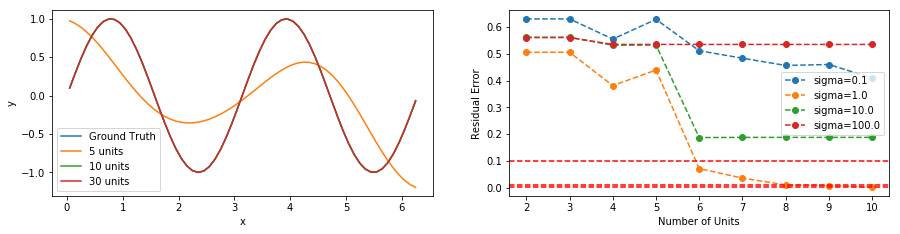

In [9]:
profile_nodes_sigma(x, x_test, y_sin, y_sin_test, nodes_profile=range(2, 11), nodes_preview=[5,10,30],
                    kwargs_network={'node_std': np.logspace(-1, 2, 4)}, 
                    kwargs_training={'training': 'least_squares'})

Delta rule.

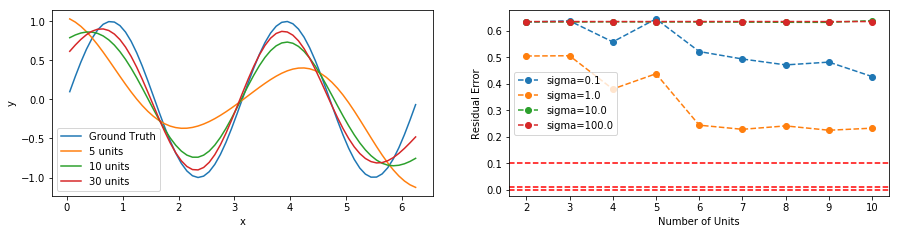

In [10]:
profile_nodes_sigma(x, x_test, y_sin, y_sin_test, nodes_profile=range(2, 11), nodes_preview=[5,10,30],
                    kwargs_network={'node_std': np.logspace(-1, 2, 4)},
                    kwargs_training={'training': 'delta_rule'})

#### 3.2.2. What can you say about the rate of convergence and its dependence on the learning rate, eta, for the two learning schemes?

In [11]:
def profile_convergence(x, x_test, y, y_test, kwargs_network={}, kwargs_training={}, runs=DEFAULT_RUNS):

    if 'training' in kwargs_training:
        training = kwargs_training['training']
        kwargs_training.pop('training')
    else:
        training = DEFAULT_TRAINING
    
    if 'node_std' in kwargs_network:
        node_std = kwargs_network['node_std']
        kwargs_network.pop('node_std')
    else:
        node_std = DEFAULT_NODE_STD
        
    if 'learning_rate' in kwargs_training:
        learning_rate = kwargs_training['learning_rate']
        kwargs_training.pop('learning_rate')
    else:
        learning_rate = DEFAULT_LEARNING_RATE_DELTA
    
    if 'epochs' in kwargs_training:
        epochs = kwargs_training['epochs']
        kwargs_training.pop('epochs')
    else:
        epochs = DEFAULT_EPOCHS_DELTA

    # Define auxiliary function for computing the MAE by epochs given a learning rate
    def learning_curve(learning_rate):
        residuals = []
        for _ in range(epochs):
            model.delta_rule_train(x, y, learning_rate=learning_rate, epochs=1, improve=True,
                                   **kwargs_training)
            predictions_test = model.predict(x_test)
            residuals.append(np.mean(np.mean(np.abs(predictions_test-y_test.reshape(y_test.shape[0], 1)))))
        
        return residuals

    # Create learning curves
    cmap = plt.get_cmap('tab10')
    for i, lr in enumerate(learning_rate):
        if kwargs_network.get('node_pos')=='random':
            for r in range(runs):
                # Initialize model
                model = GaussianRBFNetwork(data=x, **kwargs_network)
                plt.plot(range(1, epochs+1), learning_curve(lr), color=cmap(i), alpha=0.3, linewidth=5, 
                         label="eta="+str(lr))
        else:
            # Initialize model
            model = GaussianRBFNetwork(data=x, **kwargs_network)    
            plt.plot(range(1, epochs+1), learning_curve(lr), label="eta="+str(lr))
    for residual_threshold in [0.1,0.01,0.001]:
        plt.axhline(residual_threshold, color='r', linestyle='--')
    plt.xlabel("Epoch")
    plt.ylabel("Residual Error")
    plt.legend()

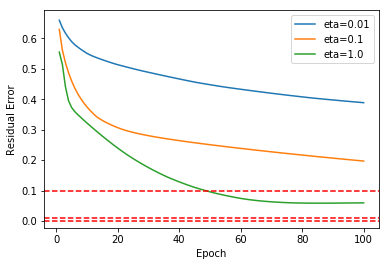

In [12]:
profile_convergence(x, x_test, y_sin, y_sin_test,
                    kwargs_training={'learning_rate': np.logspace(-2, 0, 3)})

#### 3.2.3. What are the main effets of changing the width of RBFs?

In [13]:
def profile_rbf_widths(x, x_test, y, y_test, kwargs_network={}, kwargs_training={}):

    plt.plot(x_test, y_test, label="Ground Truth")

    if 'training' in kwargs_training:
        training = kwargs_training['training']
        kwargs_training.pop('training')
    else:
        training = DEFAULT_TRAINING
    
    if 'node_std' in kwargs_network:
        node_std = kwargs_network['node_std']
        kwargs_network.pop('node_std')
    else:
        node_std = DEFAULT_NODE_STD
        
    for sigma in [node_std] if type(node_std) in [float,int] else node_std:
        model = GaussianRBFNetwork(data=x, node_std=sigma, **kwargs_network)
        if training == 'least_squares':
            model.least_squares_fit(x, y)
        elif training == 'delta_rule':
            model.delta_rule_train(x, y, **kwargs_training)
        predictions_test = model.predict(x_test)
        plt.plot(x_test, predictions_test, label="sigma="+str(sigma))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()

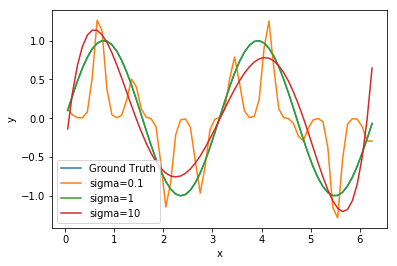

In [14]:
profile_rbf_widths(x, x_test, y_sin, y_sin_test, kwargs_network={'node_std': [0.1,1,10]})

#### 3.2.4. How important is the positioning of the RBF nodes in the input space? What strategy did you choose? Is it better than random positioning of the RBF nodes?

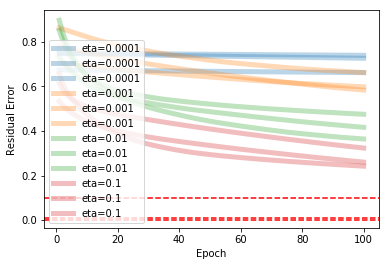

In [15]:
profile_convergence(x, x_test, y_sin, y_sin_test, kwargs_network={'node_pos': 'random'},
                    kwargs_training={'learning_rate': np.logspace(-4, -1, 4)}, runs=3)

#### 3.2.5. Also, for the same network models estimate their test performance on the original clean data used in section 3.1 (a corresponding test subset but without noise) and compare your findings.

In [16]:
def profile_clean_performance(x, y_noisy, x_test, y_test, nodes_preview, kwargs_network={}, 
                              kwargs_training={}):    

    def fit_model(nodes, sigma=DEFAULT_NODE_STD):
        model = GaussianRBFNetwork(data=x, nodes=nodes, node_std=sigma, **kwargs_network)
        if training == 'least_squares':
            model.least_squares_fit(x, y_noisy)
        elif training == 'delta_rule':
            model.delta_rule_train(x, y_noisy, **kwargs_training)
        
        return model
    
    # Preview Least Squares
    training = 'least_squares'
    fig = plt.figure(figsize=(15,7.5))
    fig.add_subplot(221)
    plt.plot(x_test, y_test, label="Ground Truth")
    for ns in nodes_preview:
        model = fit_model(ns)
        predictions_test_clean = model.predict(x_test)
        plt.plot(x_test, predictions_test_clean, label=str(ns)+" units")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title("Least Squares trained on noisy")
    
    # Preview Delta Rule
    training = 'delta_rule'
    fig.add_subplot(222)
    plt.plot(x_test, y_test, label="Ground Truth")
    for ns in nodes_preview:
        model = fit_model(ns)
        predictions_test_clean = model.predict(x_test)
        plt.plot(x_test, predictions_test_clean, label=str(ns)+" units")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.title("Delta rule trained on noisy")

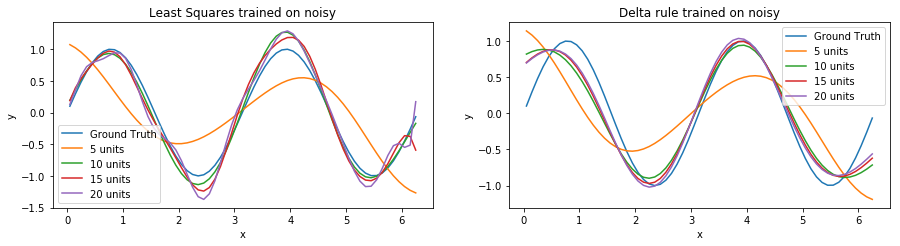

In [17]:
profile_clean_performance(x, y_noisy_sin, x_test, y_sin_test, nodes_preview=[5,10,15,20],
                          kwargs_network={}, kwargs_training={})

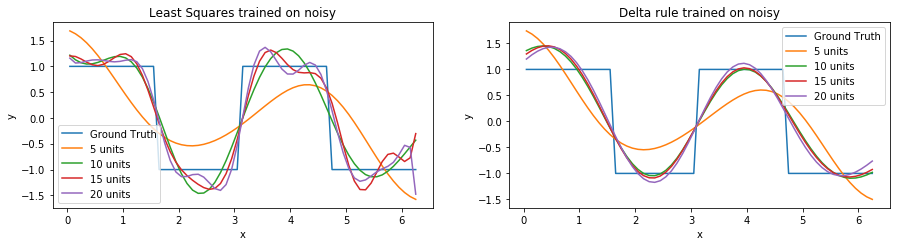

In [18]:
profile_clean_performance(x, y_noisy_square, x_test, y_square_test, nodes_preview=[5,10,15,20], 
                          kwargs_network={}, kwargs_training={})

### 3.3. Competitive learning (CL) to initialise RBF units

#### 3.3.1. Compare the CL-based approach with your earlier RBF network where you manually positioned RBF nodes in the input space. Pay attention to convergence, generalisation performance and the resulting position of nodes.

Define a function for visualizing RBF positioning schemes.

In [19]:
def rbf_pos_preview(x, y, kwargs_network={}):

    if 'node_pos' in kwargs_network:
        node_pos = kwargs_network['node_pos']
        kwargs_network.pop('node_pos')
    else:
        training = DEFAULT_NODE_POS

    fig = plt.figure(figsize=(15,5))
    for plot, pos in enumerate(node_pos):
        fig.add_subplot(130+plot+1)
        plt.plot(x, y, label="Input")
        model = GaussianRBFNetwork(data=x, node_pos=pos, **kwargs_network)
        for j, mu in enumerate(model.mu):
            rbf = np.exp(-(x-mu)**2/(2*model.cov[j]))
            plt.plot(x, rbf, label=("RBF" if j == 0 else None))
        plt.title(pos.capitalize())
        plt.legend()

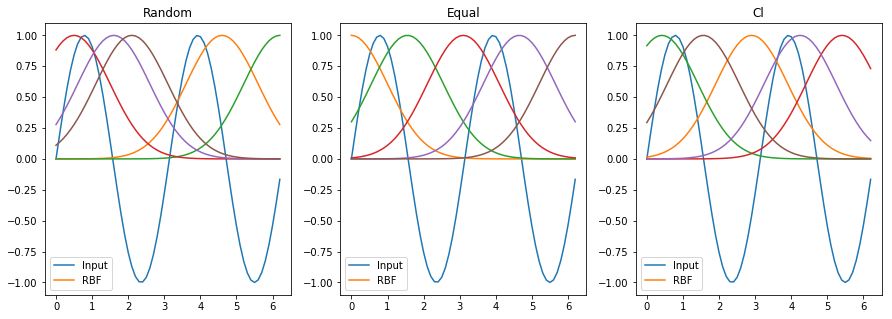

In [20]:
rbf_pos_preview(x , y_sin, kwargs_network={'nodes': 5, 'node_pos': ['random','equal','cl']})

Define a funtion for plotting the earning curves by RBF positioning schemes.

In [21]:
def rbf_pos_compare(x, y, x_test, y_test, kwargs_network=None, kwargs_training=None, runs=DEFAULT_RUNS):

    if 'node_pos' in kwargs_network:
        node_pos = kwargs_network['node_pos']
        kwargs_network.pop('node_pos')
    else:
        training = DEFAULT_NODE_POS
        
    if 'nodes' in kwargs_network:
        nodes = kwargs_network['nodes']
        kwargs_network.pop('nodes')
    else:
        nodes = DEFAULT_NODES

    if 'epochs' in kwargs_training:
        epochs = kwargs_training['epochs']
        kwargs_training.pop('epochs')
    else:
        nodes = DEFAULT_EPOCHS_DELTA
 
    cmap = plt.get_cmap('tab10')
    for i, pos in enumerate(node_pos):
        for r in range(runs):
            model = GaussianRBFNetwork(data=x, nodes=nodes, node_pos=pos, **kwargs_network)
            residuals = []
            for _ in range(epochs):
                model.delta_rule_train(x, y, epochs=1, improve=True, **kwargs_training)
                predictions_test = model.predict(x_test)
                errors = predictions_test-y_test.reshape(y_test.shape[0], 1)
                residuals.append(np.mean(np.mean(np.abs(errors))))
            plt.plot(range(1, epochs+1), residuals, color=cmap(i), alpha=0.3, linewidth=3,
                     label=(pos.capitalize() if r==0 else None))
    plt.xlabel("Epoch")
    plt.ylabel("Residual Error")
    plt.legend()

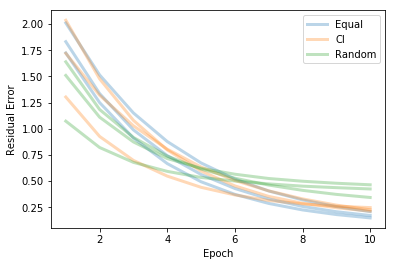

In [22]:
rbf_pos_compare(x, y_sin, x_test, y_sin_test, 
                kwargs_network={'nodes': 23,
                                'node_pos': ['equal','cl',"random"],
                                'node_std': 0.1},
                kwargs_training={'learning_rate': 0.01,
                                 'epochs': 10},
                runs=3)

#### 3.3.2. Introduce a strategy to avoid dead units, e.g. by having more than a single winner.

Define a function for plotting the units.

In [23]:
def plot_units(mus, covs, color, label=None):
    for i, (mu, cov) in enumerate(zip(mus, covs)):
        ax.scatter(*mu, color=color, label=(label if i==0 else None))
        from matplotlib.patches import Circle, Ellipse
        c = Circle(mu, radius=np.sqrt(cov), color=color, fill=False, linewidth=2)
        ax.add_artist(c)

CL summary:
  - Weights and Winning Times are:
 x:  [-5. -5.]  ->  0
 x:  [5. 5.]  ->  0
 x:  [-0.30796414 -0.08437157]  ->  10000
CL summary:
  - Weights and Winning Times are:
 x:  [ 1.23685389 -0.5317909 ]  ->  3335
 x:  [-0.41418063  0.74994684]  ->  3334
 x:  [-0.71494919 -0.77426792]  ->  3331


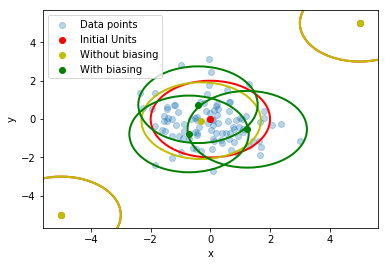

In [24]:
fig, ax = plt.subplots(1, 1)

# Plot datapoints
x, y = np.hsplit(np.random.multivariate_normal((0,0), np.eye(2), size=(100)), 2)
ax.scatter(x, y, label="Data points", alpha=0.3)

# Plot initial units
mus = [(-5,-5),(5,5),(0,0)]
std = 2
covs = np.full(len(mus),std**2)
plot_units(mus, covs, color='r', label="Initial Units")

# Plot final units without biasing
model = GaussianRBFNetwork(data=np.hstack((x,y)), nodes=len(mus), node_pos='manual')
model.mu = np.array(mus, dtype=float)
model.cov = np.array(covs, dtype=float)
model.init_kernels_cl(std=std, random_start=False, learning_rate=0.1, verbose=True, bias=False)
plot_units(model.mu, model.cov, color='y', label="Without biasing")

# Plot final units with biasing
model.mu = np.array(mus, dtype=float)
model.cov = np.array(covs, dtype=float)
model.init_kernels_cl(std=std, random_start=False, learning_rate=0.1, bias=True, bias_weight=0.1,
                      verbose=True)
plot_units(model.mu, model.cov, color='g', label="With biasing")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

#### 3.3.3. Configure an RBF network with the use of CL for positioning the RBF units to approximate a two-dimensional function, i.e. from R^2 to R^2 (Approximate Ballistic function)

Load data.

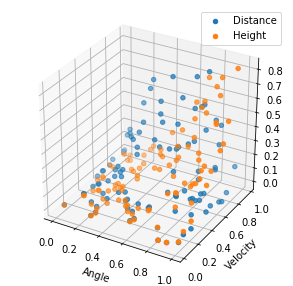

In [25]:
angles, velocities, distances, heights = np.hsplit(np.genfromtxt("data_lab2/ballist.dat"), 4)
inputs = np.hstack((angles,velocities))

# 3D predictions
fig = plt.figure(figsize=(5,5))
fig3d = fig.add_subplot(1, 1, 1, projection='3d')
fig3d.scatter(angles, velocities, distances, label="Distance")
fig3d.scatter(angles, velocities, heights, label="Height")
fig3d.set_xlabel("Angle")
fig3d.set_ylabel("Velocity")
fig3d.legend()

Preview unit placement.

In [26]:
model = GaussianRBFNetwork(data=inputs, nodes=5, node_pos='cl', node_std=0.1, cl_bias=True, 
                           cl_verbose=True)

CL summary:
  - Weights and Winning Times are:
 x:  [0.60204699 0.74928281]  ->  1999
 x:  [0.18070318 0.25293987]  ->  2009
 x:  [0.70585423 0.26331301]  ->  1996
 x:  [0.88667058 0.65395021]  ->  1996
 x:  [0.21628738 0.67518258]  ->  2000


Plot the data and the units.

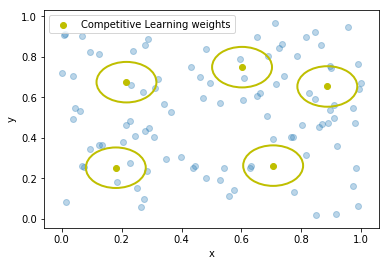

In [27]:
fig, ax = plt.subplots(1, 1)

# Plot data points
ax.scatter(angles, velocities, alpha=0.3)

# Plot final units without biasing
plot_units(model.mu, model.cov, color='y', label="Competitive Learning weights")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

Find a good model.

In [28]:
# Shuffle samples
shuffle = np.random.permutation(inputs.shape[0])
inputs_shuffled = inputs[shuffle,:]
distances_shuffled = distances[shuffle,:]
heights_shuffled = heights[shuffle,:]

# Split into training and validation data
n_train = int(0.8*inputs_shuffled.shape[0])
inputs_train, inputs_val = inputs_shuffled[:n_train,:], inputs_shuffled[n_train:,:]
distances_train, distances_val = distances_shuffled[:n_train,:], distances_shuffled[n_train:,:]
heights_train, heights_val = heights_shuffled[:n_train,:], heights_shuffled[n_train:,:]

# Read test data
angles_test, velocities_test, distances_test, heights_test = \
    np.hsplit(np.genfromtxt("data_lab2/balltest.dat"),4)
inputs_test = np.hstack((angles_test,velocities_test))

In [29]:
def gridsearch(inputs_train, outputs_train, inputs_val, outputs_val, kwargs_network={}, 
               kwargs_training={}, runs=DEFAULT_RUNS, verbose=False):
    
    if verbose:
        cols = ["Units","Sigma","Training","Node position","MSE (mean)","MSE (std)"]
        print(cols)
 
    if 'nodes' in kwargs_network:
        nodes = kwargs_network['nodes']
        kwargs_network.pop('nodes')
    else:
        nodes = DEFAULT_NODES
    
    if 'node_pos' in kwargs_network:
        node_pos = kwargs_network['node_pos']
        kwargs_network.pop('node_pos')
    else:
        node_pos = DEFAULT_NODE_POS
        
    if 'node_std' in kwargs_network:
        node_std = kwargs_network['node_std']
        kwargs_network.pop('node_std')
    else:
        node_std = DEFAULT_NODE_STD
    
    if 'training' in kwargs_training:
        trainings = kwargs_training['training']
        kwargs_training.pop('training')
    else:
        trainings = DEFAULT_TRAINING    

    mse_min = np.inf
    
    for ns in [nodes] if type(nodes) in [float,int] else nodes:
        for sigma in [node_std] if type(node_std) in [float,int] else node_std:
            for training in [trainings] if type(trainings) in [str] else trainings:
                for pos in [node_pos] if type(node_pos) in [str] else node_pos:
                    mses = []
                    for _ in range(runs):
                        model = GaussianRBFNetwork(data=inputs_train, nodes=ns, node_std=sigma, 
                                                   node_pos=pos, **kwargs_network)
                        # Preview Unit Placement
                        if training == 'least_squares':
                            model.least_squares_fit(inputs_train, outputs_train)
                        elif training == 'delta_rule':
                            model.delta_rule_train(inputs_train, outputs_train, **kwargs_training)
                        predictions_val = model.predict(inputs_val)
                        errors = predictions_val-outputs_val.reshape(outputs_val.shape[0], 1)
                        mses.append(np.mean(np.abs(errors)))
                    mse_mean = np.mean(mses)
                    mse_std = np.std(mses)
                    if mse_mean < mse_min:
                        best_model = {"nodes": ns, "sigma": sigma, "training": training, 
                                      "node_pos": pos, "mse_mean": mse_mean, "mse_std": mse_std}
                        mse_min = mse_mean
                    if verbose:
                        print([ns,sigma,training,pos,mse_mean,mse_std])

    print("Best Model:")
    print(best_model)
    
    return best_model

In [30]:
# Good model for distances
best_model_distances = gridsearch(inputs_train, distances_train, inputs_val, distances_val,
                                  kwargs_network={'nodes': [10,20,30],
                                                  'node_pos':['cl','random','equal'],
                                                  'node_std': [0.1,0.25,0.5],
                                                  "cl_bias":True},
                                  kwargs_training={'training': ['least_squares','delta_rule'],
                                                   "epochs":25},
                                  runs=3, verbose=False)

Best Model:
{'nodes': 30, 'sigma': 0.5, 'training': 'least_squares', 'node_pos': 'cl', 'mse_mean': 0.0006960081697343131, 'mse_std': 1.950825225419147e-05}


In [31]:
# Good model for heights
best_model_heights = gridsearch(inputs_train, heights_train, inputs_val, heights_val,
                                kwargs_network={'nodes': [10,20,30],
                                                'node_pos':['cl','random','equal'],
                                                'node_std': [0.1,0.25,0.5],
                                                "cl_bias":True},
                                kwargs_training={'training': ['least_squares','delta_rule'],
                                                 "epochs":25},
                                runs=3, verbose=False)

Best Model:
{'nodes': 30, 'sigma': 0.5, 'training': 'least_squares', 'node_pos': 'cl', 'mse_mean': 0.0003691608252751441, 'mse_std': 3.881500590610759e-05}


Evaluate the models by plotting predictions in 3D.

In [32]:
def evaluate(model, inputs_test, outputs_test, show_points=True, show_surface=True):
    
    # Compute prediction
    predictions_test = model.predict(inputs_test)
    mse = np.mean(np.abs(predictions_test-outputs_test.reshape(outputs_test.shape[0], 1)))
    
    # Set up figure
    fig = plt.figure(figsize=(15,7.5))
    ax1 = fig.add_subplot(121, projection='3d')
    ax2 = fig.add_subplot(122, projection='3d')
    cmap = plt.get_cmap('tab10')
    
    # Scatter plots
    ax1.scatter(inputs_test[:,0], inputs_test[:,1], outputs_test, label="Ground Truth")
    ax1.scatter(inputs_test[:,0], inputs_test[:,1], predictions_test, color=cmap(1), label="Prediction")
    ax2.scatter(inputs_test[:,0], inputs_test[:,1], abs(predictions_test-outputs_test), color=cmap(2),
                alpha=0.5, label="|Prediction - Ground Truth| - MSE "+str(mse))
    # Format axes
    for ax in ax1, ax2:
        ax.set_xlabel("Angle")
        ax.set_ylabel("Velocity")
        ax.legend()
    ax2.ticklabel_format(style='sci', axis='z', scilimits=(0,0))

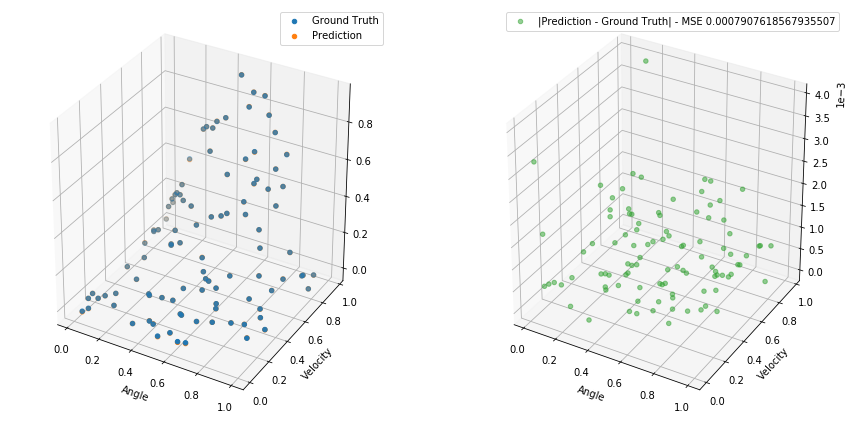

In [33]:
# Evaluate the model for distances
kwargs_network = {"cl_bias": True}
kwargs_training = {"epochs": 25}
nodes = best_model_distances["nodes"]
sigma = best_model_distances["sigma"]
training = best_model_distances["training"]
node_pos = best_model_distances["node_pos"]

model_distances = GaussianRBFNetwork(data=inputs_train, nodes=nodes, node_std=sigma, node_pos=node_pos,
                                     **kwargs_network)

if training == 'least_squares':
    model_distances.least_squares_fit(inputs_train, distances_train)
elif training == 'delta_rule':
    model_distances.delta_rule_train(inputs_train, distances_train, **kwargs_training)

evaluate(model_distances, inputs_test, distances_test)

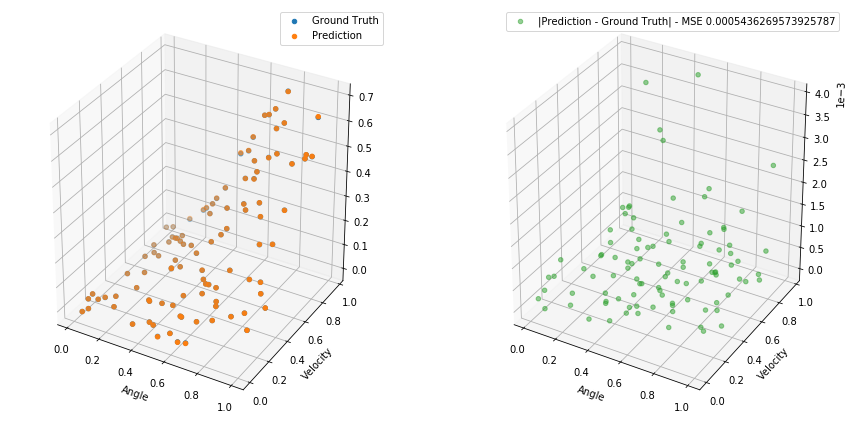

In [34]:
# Evaluate the model for heights
kwargs_network = {"cl_bias": True}
kwargs_training = {"epochs": 25}
nodes = best_model_heights["nodes"]
sigma = best_model_heights["sigma"]
training = best_model_heights["training"]
node_pos = best_model_heights["node_pos"]

model_heights = GaussianRBFNetwork(data=inputs_train, nodes=nodes, node_std=sigma, node_pos=node_pos,
                                   **kwargs_network)

if training == 'least_squares':
    model_heights.least_squares_fit(inputs_train, heights_train)
elif training == 'delta_rule':
    model_heights.delta_rule_train(inputs_train, heights_train, **kwargs_training)

evaluate(model_heights, inputs_test, heights_test)

## 4. Assignment - Part 2

Define the function for SOM.

In [35]:
def som(inputs, outputs, learning_rate=0.2, epochs=20, neighbourhood='simple', neighbourhood_init=50, 
        seed=1):
   
    n_float = neighbourhood_init
    n_step = neighbourhood_init/epochs
    np.random.seed(seed)
    
    # Define the neighbourhood indexes and centroids or weights
    if neighbourhood=='grid':        
        output_ind = np.arange(np.prod(outputs)).reshape(outputs)        
        weights = np.random.uniform(0, 1, size=(np.prod(outputs), inputs.shape[1]))
    else:
        output_ind = list(range(outputs))
        weights = np.random.uniform(0, 1, size=(outputs,inputs.shape[1]))

    # Iterate epochs
    for _ in range(epochs):
        
        # Iterate the input data sample by sample
        for row in inputs:
            
            # Find the winner output node (closest to sample)
            winner = np.argmin(la.norm(weights-row, axis=1))
            
            # Find the indexes of neighbourhood
            n_r = int(n_float)
            if neighbourhood == 'grid':
                winner_x, winner_y = np.unravel_index(winner, outputs)
                ind = []
                for i in range(output_ind.shape[0]):
                    for j in range(output_ind.shape[1]):
                        if (abs(winner_x-i)+abs(winner_y-j))<=n_r:
                            ind.append(output_ind[i,j])
            elif neighbourhood == 'cyclic':
                n_low = winner-n_r
                n_high = winner+n_r+1
                if n_low<0:
                    ind = output_ind[n_low:]+output_ind[:n_high]
                elif n_high>outputs:
                    ind = output_ind[n_low:]+output_ind[:(n_high-outputs)]
                else:
                    ind = output_ind[n_low:n_high]
            elif neighbourhood == 'simple':
                n_low = max(0, winner-n_r)
                n_high = min(outputs, winner+n_r+1)
                ind = range(n_low, n_high)

            delta = learning_rate*(row-weights[ind,:])
            weights[ind,:] += delta

        n_float -= n_step

    predicted_output_node = [np.argmin(la.norm(weights-row, axis=1)) for row in inputs]
    order_inputs = np.argsort(predicted_output_node)
    
    return np.array(predicted_output_node), order_inputs, weights

### 4.1. Topological Ordering of Animal Species

Apply it to animals data (32 animals with 84 features).

In [36]:
animals_input = np.genfromtxt('data_lab2/animals.dat', delimiter=',').reshape(32, 84)
txt = open('data_lab2/animalnames.txt', 'r')
animals_names = [line.strip("'\t\n") for line in txt]
predicted_output_node, order_inputs, weights = som(animals_input, outputs=100, seed=1)
[print(animals_names[i], " in output node ", predicted_output_node[i]) for i in order_inputs]

dragonfly  in output node  0
grasshopper  in output node  1
beetle  in output node  1
butterfly  in output node  4
housefly  in output node  7
moskito  in output node  10
spider  in output node  16
pelican  in output node  23
duck  in output node  27
penguin  in output node  30
ostrich  in output node  35
frog  in output node  41
seaturtle  in output node  44
crocodile  in output node  45
walrus  in output node  51
bear  in output node  57
hyena  in output node  57
dog  in output node  60
rabbit  in output node  67
rat  in output node  70
bat  in output node  73
cat  in output node  77
lion  in output node  78
ape  in output node  81
skunk  in output node  86
elephant  in output node  89
kangaroo  in output node  92
antelop  in output node  93
horse  in output node  96
giraffe  in output node  99
camel  in output node  99
pig  in output node  99


### 4.2 Cyclic Tour

Load the data (10 points or locations with 2 features or positions).

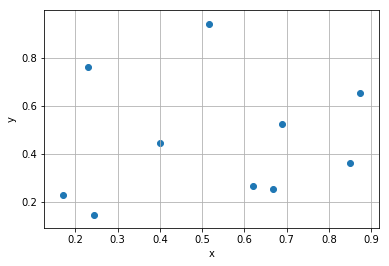

In [37]:
dat = open('data_lab2/cities.dat', 'r')
clean = [line.replace(';', '') for line in dat]
cities = np.genfromtxt(clean, comments='%', delimiter=',')
plt.scatter(cities[:,0], cities[:,1])
plt.xlabel("x")
plt.ylabel("y")
plt.grid()

Define a function to plot the tour (output of SOM).

In [38]:
def plot_tour(cities, predicted_output_node, order_inputs, weights):

    def plot_arrow(start, end, color):
        start_x, start_y = start
        end_x, end_y = end
        plt.arrow(start_x, start_y, end_x-start_x, end_y-start_y, color = color, head_width=0.02,
                  length_includes_head=True,zorder=1)

    cmap = plt.get_cmap('tab10')

    # Plot fitted SOM weights
    plt.figure(figsize=(7.5,7.5))
    plt.scatter(weights[:,0], weights[:,1], zorder=2, color=cmap(0), label="Fitted weights - tour")

    # Plot real cities
    plt.scatter(cities[:,0], cities[:,1], zorder=2, color=cmap(1), label="Real cities - tour")

    # Plot curve and tour
    predicted_output_node.sort()
    for i in range(-1, len(order_inputs)-1):
        
        # Fitted weights tour
        if predicted_output_node[i]!=predicted_output_node[i+1]:
            plot_arrow(weights[predicted_output_node[i]], weights[predicted_output_node[i+1]], 
                       color=cmap(0))
        
        # Real cities tour
        plot_arrow(cities[order_inputs[i]], cities[order_inputs[i+1]], color=cmap(1)) 
    
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid()

Apply the SOM in cyclic neighbourhood method.

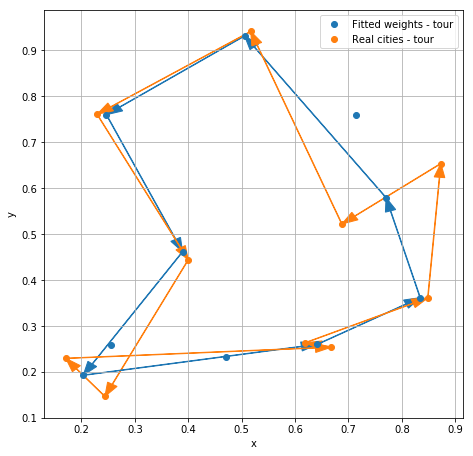

In [39]:
predicted_output_node, order_inputs, weights = som(cities, outputs=10, neighbourhood='cyclic', 
                                                   neighbourhood_init=2)
plot_tour(cities, predicted_output_node, order_inputs, weights)

### 4.3 Data Clustering: Votes of MPs

Load the data 349 members of parlaments with 31 different votes as features.

In [40]:
votes = np.genfromtxt('data_lab2/votes.dat', delimiter=',').reshape(349, 31)
party = np.genfromtxt('data_lab2/mpparty.dat', comments='%', dtype=np.uint8)
district = np.genfromtxt('data_lab2/mpdistrict.dat', comments='%', dtype=np.uint8)
sex = np.genfromtxt('data_lab2/mpsex.dat', comments='%', dtype=np.uint8)
mp_attrs = np.column_stack((party,district,sex))
mp_attr_names = ["Party","District","Sex"]
mp_attr_levels = [
    ["No Party","The Moderate Party","Liberal People's Party","The Social Democrats","The Left Party",
     "The Greens","Christian Democrats","Centre Party"],
    ["District "+str(d) for d in np.unique(district)],
    ["Male","Female"]
]

Apply the SOM in grid neighbourhood method.

In [41]:
gridsize = (10,10)
predicted_output_node, order_inputs, weights = som(votes, outputs=gridsize, neighbourhood='grid',
                                                   neighbourhood_init=4, epochs=5)

Plot the grid or SOM units by features.

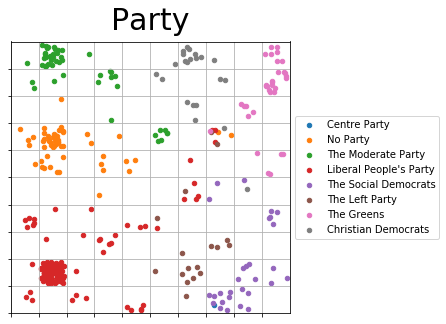

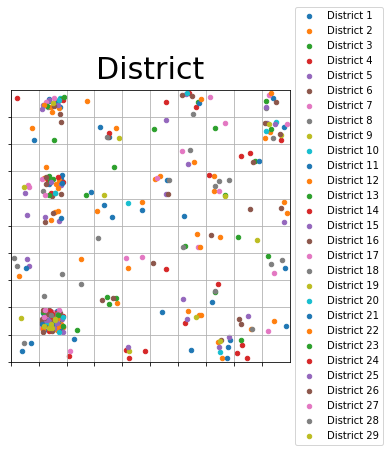

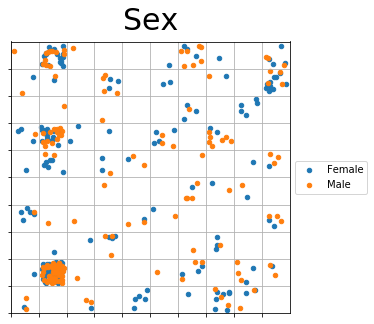

In [42]:
# Define a function to add noise to points and then do not plot all points in exactly same coordinate
def noisy_index(point, noise=0.4):
    return point.astype(float)+np.random.uniform(-noise, noise, size=point.shape)

cmap = plt.get_cmap()

# Iterate feature names
for attr in range(len(mp_attr_names)):
    fig = plt.figure(figsize=(5,5))  
    
    # Iterate unique values in that feature
    for val in np.unique(mp_attrs[:,attr]):
        
        # Find the output node assigned to each minister with that feature value
        x, y = np.unravel_index(predicted_output_node[mp_attrs[:,attr]==val], gridsize)
        
        # Plot the position in output space of each minister with that feature value
        plt.scatter(noisy_index(x), noisy_index(y), s=20, alpha=1, label=mp_attr_levels[attr][val-1])
    
    # Edit the plot
    plt.title(mp_attr_names[attr], fontsize=30, y=1.02)
    plt.xticks(np.arange(-0.5, gridsize[0]-0.5, 1), labels=[])
    plt.yticks(np.arange(-0.5, gridsize[1]-0.5, 1), labels=[])
    plt.grid(True)
    plt.xlim([-0.5, gridsize[0]-0.5])
    plt.ylim([-0.5, gridsize[1]-0.5])
    plt.legend(loc='center left', bbox_to_anchor=(1,0.5))